# Import and declaring certain arguments

In [1]:
# coding: utf-8
import argparse
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx
import data
import model
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:

class Args:
  data = './data/wikitext-2'
  model = 'FNNModel'
  emsize = 200
  context_size = 8
  nhid = 200
  nlayers = 2
  lr = 20
  clip = 0.25
  epochs = 40
  batch_size = 8
  bptt = 35
  dropout = 0.2
  tied = True
  seed = 1111
  cuda = True
  log_interval = 200
  save = 'model.pt'
  onnx_export = ''
  nhead = 2
  dry_run =  True

args=Args()

In [3]:
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")



# Loading the data

In [4]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args.data)

# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.


In [5]:
torch.set_printoptions(edgeitems=100)
print(corpus.train)

tensor([    0,     1,     2,     3,     4,     1,     0,     0,     5,     6,
            2,     7,     8,     9,     3,    10,    11,     8,    12,    13,
           14,    15,     2,    16,    17,    18,     7,    19,    13,    20,
           21,    22,    23,     2,     3,     4,    24,    25,    13,    26,
           27,    28,    29,    30,    31,    32,    33,    34,    35,    36,
           37,    38,    39,    17,    40,    41,    15,    42,    43,    44,
           45,    43,    25,    13,    46,    26,    17,    47,    33,    43,
           17,     2,    48,    15,     9,    17,    49,    50,    16,    28,
           37,    51,    30,    52,    53,    23,    54,    55,    13,    17,
           56,    57,    58,    22,    17,    59,    33,    37,    60,    17,
         ...,    93,   622,    22,  5002,    78,  6656,  7628,    43,   293,
         1043,    15,  5277,  4726,   284, 23960,    26,   494,   489,   151,
        27535,   348,  4737,    43, 17444,    39,    17,  2532,  

In [6]:
# # we want to return a tensor with ascending batch 

# def batchify(data, bsz):
#     # Work out how cleanly we can divide the dataset into bsz parts.
#     nbatch = data.size(0) // bsz
#     # Trim off any extra elements that wouldn't cleanly fit (remainders).
#     data = data.narrow(0, 0, nbatch * bsz)
#     # Evenly divide the data across the bsz batches.
#     data = data.view(-1, bsz).contiguous()
#     return data.to(device)

# eval_batch_size = 8
# train_data = batchify(corpus.train, args.batch_size)
# val_data = batchify(corpus.valid, eval_batch_size)
# test_data = batchify(corpus.test, eval_batch_size)

In [7]:
def batchify(data, bsz):
    value=[]
    data = data.numpy()
    for i,word in enumerate(data):
        if i+bsz>= len(data):
            # sentence boundary reached
            # ignoring sentence less than 3 words
            break
        # convert word to id
        value1 = []
        for j in range(bsz+1):
            value1.append(data[i+j])
        value.append(value1)
    value = torch.LongTensor(value)
    return value.to(device)

In [8]:
eval_batch_size = 8
train_data = batchify(corpus.train, args.context_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)

In [9]:
torch.set_printoptions(edgeitems=100)
print(train_data)

tensor([[    0,     1,     2,     3,     4,     1,     0,     0,     5],
        [    1,     2,     3,     4,     1,     0,     0,     5,     6],
        [    2,     3,     4,     1,     0,     0,     5,     6,     2],
        [    3,     4,     1,     0,     0,     5,     6,     2,     7],
        [    4,     1,     0,     0,     5,     6,     2,     7,     8],
        [    1,     0,     0,     5,     6,     2,     7,     8,     9],
        [    0,     0,     5,     6,     2,     7,     8,     9,     3],
        [    0,     5,     6,     2,     7,     8,     9,     3,    10],
        [    5,     6,     2,     7,     8,     9,     3,    10,    11],
        [    6,     2,     7,     8,     9,     3,    10,    11,     8],
        [    2,     7,     8,     9,     3,    10,    11,     8,    12],
        [    7,     8,     9,     3,    10,    11,     8,    12,    13],
        [    8,     9,     3,    10,    11,     8,    12,    13,    14],
        [    9,     3,    10,    11,     8,    12, 

# Declaring data loader functions 

In [10]:
# get the train and target for the train values
def get_batch(source, i):
    seq_len = min(args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len, 0:args.context_size]
    target = source[i+1:i+1+seq_len, args.context_size-1:args.context_size]
    target = target.narrow(1,0,1).contiguous().view(-1)
    return data, target

In [11]:
data, target = get_batch(train_data, 0)

In [12]:
print(data)

tensor([[ 0,  1,  2,  3,  4,  1,  0,  0],
        [ 1,  2,  3,  4,  1,  0,  0,  5],
        [ 2,  3,  4,  1,  0,  0,  5,  6],
        [ 3,  4,  1,  0,  0,  5,  6,  2],
        [ 4,  1,  0,  0,  5,  6,  2,  7],
        [ 1,  0,  0,  5,  6,  2,  7,  8],
        [ 0,  0,  5,  6,  2,  7,  8,  9],
        [ 0,  5,  6,  2,  7,  8,  9,  3],
        [ 5,  6,  2,  7,  8,  9,  3, 10],
        [ 6,  2,  7,  8,  9,  3, 10, 11],
        [ 2,  7,  8,  9,  3, 10, 11,  8],
        [ 7,  8,  9,  3, 10, 11,  8, 12],
        [ 8,  9,  3, 10, 11,  8, 12, 13],
        [ 9,  3, 10, 11,  8, 12, 13, 14],
        [ 3, 10, 11,  8, 12, 13, 14, 15],
        [10, 11,  8, 12, 13, 14, 15,  2],
        [11,  8, 12, 13, 14, 15,  2, 16],
        [ 8, 12, 13, 14, 15,  2, 16, 17],
        [12, 13, 14, 15,  2, 16, 17, 18],
        [13, 14, 15,  2, 16, 17, 18,  7],
        [14, 15,  2, 16, 17, 18,  7, 19],
        [15,  2, 16, 17, 18,  7, 19, 13],
        [ 2, 16, 17, 18,  7, 19, 13, 20],
        [16, 17, 18,  7, 19, 13, 2

In [13]:
print(target)

tensor([ 5,  6,  2,  7,  8,  9,  3, 10, 11,  8, 12, 13, 14, 15,  2, 16, 17, 18,
         7, 19, 13, 20, 21, 22, 23,  2,  3,  4, 24, 25, 13, 26, 27, 28, 29],
       device='cuda:0')


# Building the model

In [18]:
# New FNN class
# creating our FNN model 

# Trigram Neural Network Model
class FNNModel(nn.Module):
    # Here context_size should be 8( because its 8 gram model ), embedding dimension is 200, h is number of hidden layers , can set it to 200
    def __init__(self, vocab_size, embedding_dim, context_size, h, tie_weights=False):
        super(FNNModel, self).__init__()
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, h)
        # Linear 2 is the decoder that returns a variable based on vocab size 
        self.linear2 = nn.Linear(h, vocab_size, bias = False)

        #tying the weigths of embeddings and linear decoder together 
        if tie_weights:
          if h != embedding_dim:
              raise ValueError('When using the tied flag, nhid must be equal to emsize')
          self.linear2.weight = self.embeddings.weight

        #initiating the weights 
        self.init_weights()

    #function initiainng the weights 
    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.embeddings.weight, -initrange, initrange)
        nn.init.zeros_(self.linear2.weight)
        nn.init.uniform_(self.linear2.weight, -initrange, initrange)


    def forward(self, inputs):
        # compute x': concatenation of all the 8 words in 8 gram model 
        embeds = self.embeddings(inputs).view((-1,self.context_size * self.embedding_dim))
        # compute h: tanh(W_1.x' + b)
        out = torch.tanh(self.linear1(embeds))
        # compute W_2.h
        out = self.linear2(out)
        # compute y: log_softmax(W_2.h)
        log_probs = torch.nn.functional.log_softmax(out, dim=1)
        # return log probabilities
        # BATCH_SIZE x len(vocab)
        return log_probs

# Declaring the helper functions  

In [33]:
# helper function to get accuracy from log probabilities
def get_accuracy_from_log_probs(log_probs, labels):
    probs = torch.exp(log_probs)
    predicted_label = torch.argmax(probs, dim=1)
    acc = (predicted_label == labels).float().mean()
    return acc



# helper function to evaluate model on dev data
def evaluate(model, criterion, data_source):
    model.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        dev_st = time.time()
        for it, data_tensor in enumerate(range(0, data_source.size(0) - 1, args.bptt)):
            context_tensor, target_tensor = get_batch(data_source, data_tensor)
#             context_tensor = data_tensor[:,0:2]
#             target_tensor = data_tensor[:,2]
            context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)
            log_probs = model(context_tensor)
            mean_loss += criterion(log_probs, target_tensor).item()
            mean_acc += get_accuracy_from_log_probs(log_probs, target_tensor)
            count += 1
            if it % 500 == 0: 
                print("Dev Iteration {} complete. Mean Loss: {}; Mean Acc:{}; Time taken (s): {}".format(it, mean_loss / count, mean_acc / count, (time.time()-dev_st)))
                dev_st = time.time()

    return mean_acc / count, mean_loss / count


# Training the model and evaluating on val set

In [ ]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
ntokens = len(corpus.dictionary)
model = FNNModel(ntokens, args.emsize, args.context_size, args.nhid).to(device)

# # load it to gpu
# model.cuda(gpu)

# using ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

#define epochs
epochs = 15


# ------------------------- TRAIN & SAVE MODEL ------------------------
best_acc = 0
best_per= 9999999999999999
best_model_path = None
#training set results 
loss_values=[]
ppl_values=[]
acc_values=[]

#val set results
val_loss = []
val_ppl=[]
val_acc=[]

for epoch in range(epochs):
    st = time.time()
    running_loss = 0.0
    running_ppl =0.0
    running_acc=0.0
    print("\n--- Training model Epoch: {} ---".format(epoch+1))
    for it, data_tensor in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        # context_tensor = data_tensor[:,0:2]
        # target_tensor = data_tensor[:,2]
        context_tensor, target_tensor= get_batch(train_data, data_tensor)

        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # zero out the gradients from the old instance
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy_from_log_probs(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # backward pass and update gradient
        loss.backward()
        optimizer.step()
        
        #getting thw total running loss and running perplexity
        running_loss = running_loss + loss.item()
        running_ppl = running_ppl + math.exp(loss.item())
        running_acc = running_acc+ acc


        if it % 10000 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}| ppl {:8.2f}".format(it, epoch, loss.item(), acc, (time.time()-st),  math.exp(loss.item())))
            st = time.time()
    
    #Getting the total loss, perplexity and accuracy
    total_runs = math.floor((train_data.size(0) - 1)/(args.bptt))
    loss_values.append(running_loss / total_runs)
    ppl_values.append(running_ppl / total_runs)
    acc_values.append(running_acc/ total_runs)

    #Evaluating the model on validation data set
    print("\n--- Evaluating model on dev data ---")
    dev_acc, dev_loss = evaluate(model, loss_function, val_data)
    dev_per = math.exp(dev_loss)
    print("Epoch {} complete! Development Accuracy: {}; Development Loss: {};  Development ppl: {}".format(epoch, dev_acc, dev_loss, dev_per))
    val_acc.append(dev_acc)
    val_loss.append(dev_loss)
    val_ppl.append(dev_per)

    # saving the model with lowest perplexity
    if dev_per < best_per:
        print("Best validation perplexity improved from {} to {}, saving model...".format(best_per, dev_per))
        best_per = dev_per
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        # set best model path


        
#         best_model_path = 'best_model_{}.dat'.format(epoch)
#         # saving best model
#         torch.save(model.state_dict(), best_model_path)


--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 10.411506652832031; Acc:0.0; Time taken (s): 0.010044574737548828| ppl 33239.91
Training Iteration 10000 of epoch 0 complete. Loss: 6.365409851074219; Acc:0.2857142984867096; Time taken (s): 68.67393183708191| ppl   581.38
Training Iteration 20000 of epoch 0 complete. Loss: 6.992609977722168; Acc:0.20000000298023224; Time taken (s): 69.02897691726685| ppl  1088.56
Training Iteration 30000 of epoch 0 complete. Loss: 4.205486297607422; Acc:0.34285715222358704; Time taken (s): 69.06005120277405| ppl    67.05
Training Iteration 40000 of epoch 0 complete. Loss: 4.922150611877441; Acc:0.37142857909202576; Time taken (s): 69.09920072555542| ppl   137.30
Training Iteration 50000 of epoch 0 complete. Loss: 7.231809139251709; Acc:0.08571428805589676; Time taken (s): 69.14919567108154| ppl  1382.72

--- Evaluating model on dev data ---
Dev Iteration 0 complete. Mean Loss: 5.581138610839844; Mean Acc:0.228571429848670

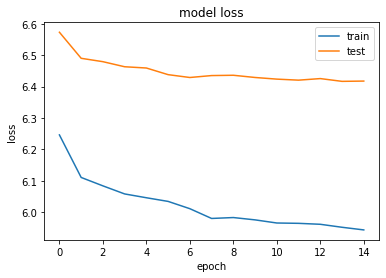

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(loss_values)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# plt.plot(loss_values)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Train loss graph')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/NLP_assignment2/results/loss.png')

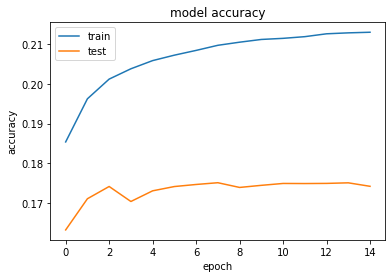

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(acc_values)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plt.plot(acc_values)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Train accuracy graph')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/NLP_assignment2/results/accuracy.png')

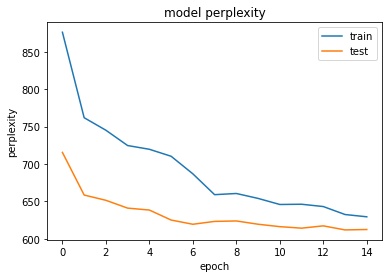

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(ppl_values)
plt.plot(val_ppl)
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# plt.plot(ppl_values)
# plt.xlabel('Epochs')
# plt.ylabel('Perplexity')
# plt.title('Train perplexity graph')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/NLP_assignment2/results/ppl.png')

# Evaluation on test set

In [ ]:
# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

In [ ]:
# Run on test data.
test_acc, test_loss = evaluate(model, loss_function, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f} | test acc {:5.2f}'.format(
    test_loss, math.exp(test_loss), test_acc))
print('=' * 89)

Dev Iteration 0 complete. Mean Loss: 5.680124282836914; Mean Acc:0.20000000298023224; Time taken (s): 0.0035195350646972656
Dev Iteration 500 complete. Mean Loss: 6.290098849408879; Mean Acc:0.17610502243041992; Time taken (s): 0.4769558906555176
Dev Iteration 1000 complete. Mean Loss: 6.309255191258022; Mean Acc:0.1764804571866989; Time taken (s): 0.4161710739135742
Dev Iteration 1500 complete. Mean Loss: 6.341735413994176; Mean Acc:0.17502592504024506; Time taken (s): 0.3851742744445801
Dev Iteration 2000 complete. Mean Loss: 6.334310414134592; Mean Acc:0.1725277602672577; Time taken (s): 0.38787364959716797
Dev Iteration 2500 complete. Mean Loss: 6.325337579182652; Mean Acc:0.1718510538339615; Time taken (s): 0.3876223564147949
Dev Iteration 3000 complete. Mean Loss: 6.266843234169924; Mean Acc:0.1763506531715393; Time taken (s): 0.38656067848205566
Dev Iteration 3500 complete. Mean Loss: 6.306699532776075; Mean Acc:0.17470096051692963; Time taken (s): 0.38921332359313965
Dev Iterat

# sharing the input (look-up matrix) and output layerembeddings (final layer weights)

In [36]:
# Using negative log-likelihood loss
loss_function = nn.NLLLoss()

# create model
ntokens = len(corpus.dictionary)
# Take note model embedding size are the same 
model = FNNModel(ntokens, args.emsize, args.context_size, args.emsize , True).to(device)

# # load it to gpu
# model.cuda(gpu)

# using ADAM optimizer
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

#define epochs
epochs = 15


# ------------------------- TRAIN & SAVE MODEL ------------------------
best_acc = 0
best_per= 9999999999999999
best_model_path = None
#training set results 
loss_values=[]
ppl_values=[]
acc_values=[]

#val set results
val_loss = []
val_ppl=[]
val_acc=[]

for epoch in range(epochs):
    st = time.time()
    running_loss = 0.0
    running_ppl =0.0
    running_acc=0.0
    print("\n--- Training model Epoch: {} ---".format(epoch+1))
    for it, data_tensor in enumerate(range(0, train_data.size(0) - 1, args.bptt)):
        # context_tensor = data_tensor[:,0:2]
        # target_tensor = data_tensor[:,2]
        context_tensor, target_tensor= get_batch(train_data, data_tensor)

        context_tensor, target_tensor = context_tensor.to(device), target_tensor.to(device)

        # zero out the gradients from the old instance
        model.zero_grad()

        # get log probabilities over next words
        log_probs = model(context_tensor)

        # calculate current accuracy
        acc = get_accuracy_from_log_probs(log_probs, target_tensor)

        # compute loss function
        loss = loss_function(log_probs, target_tensor)

        # backward pass and update gradient
        loss.backward()
        optimizer.step()
        
        #getting thw total running loss and running perplexity
        running_loss = running_loss + loss.item()
        running_ppl = running_ppl + math.exp(loss.item())
        running_acc = running_acc+ acc


        if it % 10000 == 0: 
            print("Training Iteration {} of epoch {} complete. Loss: {}; Acc:{}; Time taken (s): {}| ppl {:8.2f}".format(it, epoch, loss.item(), acc, (time.time()-st),  math.exp(loss.item())))
            st = time.time()
    
    #Getting the total loss, perplexity and accuracy
    total_runs = math.floor((train_data.size(0) - 1)/(args.bptt))
    loss_values.append(running_loss / total_runs)
    ppl_values.append(running_ppl / total_runs)
    acc_values.append(running_acc/ total_runs)

    #Evaluating the model on validation data set
    print("\n--- Evaluating model on dev data ---")
    dev_acc, dev_loss = evaluate(model, loss_function, val_data)
    dev_per = math.exp(dev_loss)
    print("Epoch {} complete! Development Accuracy: {}; Development Loss: {};  Development ppl: {}".format(epoch, dev_acc, dev_loss, dev_per))
    val_acc.append(dev_acc)
    val_loss.append(dev_loss)
    val_ppl.append(dev_per)

    # saving the model with lowest perplexity
    if dev_per < best_per:
        print("Best validation perplexity improved from {} to {}, saving model...".format(best_per, dev_per))
        best_per = dev_per
        with open(args.save, 'wb') as f:
            torch.save(model, f)
        # set best model path


        
#         best_model_path = 'best_model_{}.dat'.format(epoch)
#         # saving best model
#         torch.save(model.state_dict(), best_model_path)


--- Training model Epoch: 1 ---
Training Iteration 0 of epoch 0 complete. Loss: 10.410841941833496; Acc:0.0; Time taken (s): 0.0063915252685546875| ppl 33217.83
Training Iteration 10000 of epoch 0 complete. Loss: 6.150674343109131; Acc:0.22857142984867096; Time taken (s): 46.65420651435852| ppl   469.03
Training Iteration 20000 of epoch 0 complete. Loss: 7.674670219421387; Acc:0.17142857611179352; Time taken (s): 46.616883993148804| ppl  2153.11
Training Iteration 30000 of epoch 0 complete. Loss: 4.009619235992432; Acc:0.37142857909202576; Time taken (s): 46.66108202934265| ppl    55.13
Training Iteration 40000 of epoch 0 complete. Loss: 4.795612812042236; Acc:0.34285715222358704; Time taken (s): 46.652491331100464| ppl   120.98
Training Iteration 50000 of epoch 0 complete. Loss: 7.3600263595581055; Acc:0.17142857611179352; Time taken (s): 46.67134761810303| ppl  1571.88

--- Evaluating model on dev data ---
Dev Iteration 0 complete. Mean Loss: 5.449685573577881; Mean Acc:0.1428571492

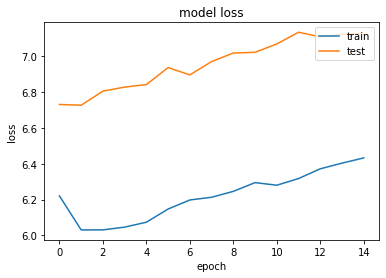

<Figure size 432x288 with 0 Axes>

In [37]:
plt.plot(loss_values)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# plt.plot(loss_values)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Train loss graph')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/NLP_assignment2/results/loss_share.png')

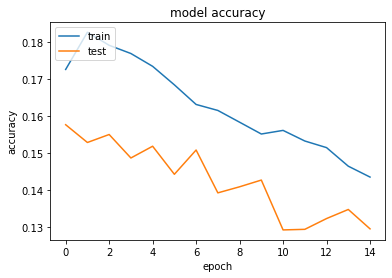

<Figure size 432x288 with 0 Axes>

In [38]:
plt.plot(acc_values)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plt.plot(acc_values)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Train accuracy graph')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/NLP_assignment2/results/accuracy_share.png')

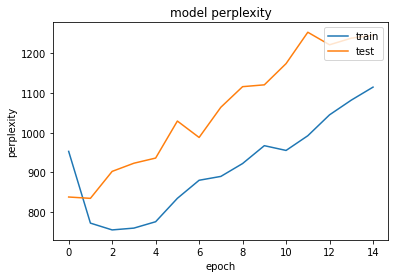

<Figure size 432x288 with 0 Axes>

In [39]:
plt.plot(ppl_values)
plt.plot(val_ppl)
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# plt.plot(ppl_values)
# plt.xlabel('Epochs')
# plt.ylabel('Perplexity')
# plt.title('Train perplexity graph')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/NLP_assignment2/results/ppl_share.png')

# generate texts using your language model 

In [19]:
class Args:
  checkpoint = './model.pt'
  outf = 'generated.txt'
  words = 1000
  seed = 1111
  cuda =  True
  temperature = 1.0
  log_interval = 100

args=Args()

In [21]:
with open(args.checkpoint, 'rb') as f:
    model = torch.load(f)
model.eval()

ntokens = len(corpus.dictionary)

input = torch.randint(ntokens, (1, 8), dtype=torch.long).to(device)
with open(args.outf, 'w', encoding='utf-8') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args.words):
#             if is_transformer_model:
#                 output = model(input, False)
#                 word_weights = output[-1].squeeze().div(args.temperature).exp().cpu()
#                 word_idx = torch.multinomial(word_weights, 1)[0]
#                 word_tensor = torch.Tensor([[word_idx]]).long().to(device)
#                 input = torch.cat([input, word_tensor], 0)
#             else:
            output = model(input)
            word_weights = output.squeeze().div(args.temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input.fill_(word_idx)

            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args.log_interval == 0:
                print('| Generated {}/{} words'.format(i, args.words))


| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words
